<a href="https://colab.research.google.com/github/akshaypat444/tensorflow_practice/blob/main/07_milestone_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Milestone project 1 - Food Vision Big

In [1]:
# Check if we have GPU with compute capability of 7 or greater
!nvidia-smi

Thu Mar  7 18:27:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-07 18:27:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-03-07 18:27:57 (8.72 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [98]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, unzip_data
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Get data using tensorflow datasets collection

In [5]:
import tensorflow_datasets as tfds

In [6]:
# Get list of all tensorflow datasets
datasets_list = tfds.list_builders()

# Check if food101 is in tensorflow dataset
print("food101" in datasets_list)

True


In [7]:
(train_data, test_data), ds_info = tfds.load("food101",
                                  split=["train", "validation"],
                                  shuffle_files=True,
                                  as_supervised=True, # Returns data in tuple format(data, lable)
                                  with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteESBGN0/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteESBGN0/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

(382, 512, 3)
<dtype: 'uint8'>
tf.Tensor(52, shape=(), dtype=int64)


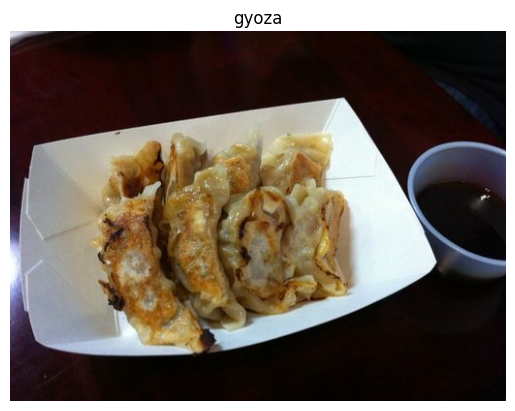

In [10]:
for img, label in train_data.take(1):
  print(img.shape)
  print(img.dtype)
  print(label)
  plt.imshow(img)
  plt.title(class_names[label.numpy()])
  plt.axis(False)

In [11]:
tf.reduce_min(img), tf.reduce_max(img)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Pre-Processing

1. Convert uint8 datatype to float32/float16
2. Convert tensors to batches
3. Scale the images to range 0-1 (Normalization)
4. Resize the images to 224,224

In [12]:
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from uint8 to float32 and
  reshapes image to (img_shape, img_shape, color_channels)
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [13]:
preprocess_img(img, label)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[207.12596  , 219.87404  , 236.77328  ],
         [206.75159  , 219.39891  , 235.39891  ],
         [206.33514  , 216.86098  , 232.36958  ],
         ...,
         [ 10.433058 ,  11.433058 ,  13.433058 ],
         [  9.974804 ,  10.974804 ,  12.974804 ],
         [ 11.004499 ,  12.004499 ,  14.004499 ]],
 
        [[214.51498  , 225.25287  , 240.26627  ],
         [214.24043  , 223.17825  , 238.07462  ],
         [213.40561  , 221.28954  , 234.25638  ],
         ...,
         [ 12.571472 ,  13.571472 ,  15.571472 ],
         [ 11.928558 ,  12.928558 ,  14.928558 ],
         [ 11.941964 ,  12.941964 ,  14.941964 ]],
 
        [[222.75032  , 229.13902  , 242.17444  ],
         [214.43494  , 220.89125  , 233.28763  ],
         [200.73564  , 205.20886  , 216.71046  ],
         ...,
         [  9.681468 ,  10.681468 ,  12.681468 ],
         [  8.874987 ,   9.874987 ,  11.874987 ],
         [  7.9464283,   8.946428 ,  10.946428

In [14]:
# Preprocess the training dataset
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle and prefetch the data
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

In [15]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Modelling callbacks

In [16]:
from functools import lru_cache
from re import L
# Create model checkpoint to save weights of best epoch
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=3)

## Setup mixed precision training

In [17]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

## Create feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

input_shape = (224,224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32",)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

24274472/24274472 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                          

In [ ]:
for layer in model.layers:
  print(layer, layer.trainable, layer.dtype, layer.dtype_policy)

<keras.src.engine.input_layer.InputLayer object at 0x78d696a0c9d0> True float32 <Policy "float32">
<keras.src.engine.functional.Functional object at 0x78d6e6c94af0> False float32 <Policy "mixed_float16">
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x78d6975ebe80> True float32 <Policy "mixed_float16">
<keras.src.layers.core.dense.Dense object at 0x78d696a0fe80> True float32 <Policy "mixed_float16">
<keras.src.layers.core.activation.Activation object at 0x78d6e6c957b0> True float32 <Policy "float32">


In [ ]:
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

In [ ]:
history_model = model.fit(train_data,
                          epochs=5,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=int(0.15 * len(test_data)),
                          callbacks=[model_checkpoint])

Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.7474 - accuracy: 0.5762

2368/2368 [==============================] - 69s 24ms/step - loss: 1.7474 - accuracy: 0.5762 - val_loss: 1.1399 - val_accuracy: 0.6984
Epoch 2/5
2366/2368 [============================>.] - ETA: 0s - loss: 1.2115 - accuracy: 0.6862

2368/2368 [==============================] - 53s 22ms/step - loss: 1.2115 - accuracy: 0.6862 - val_loss: 1.0311 - val_accuracy: 0.7248
Epoch 3/5
2368/2368 [==============================] - ETA: 0s - loss: 1.0627 - accuracy: 0.7231

2368/2368 [==============================] - 55s 23ms/step - loss: 1.0627 - accuracy: 0.7231 - val_loss: 0.9949 - val_accuracy: 0.7357
Epoch 4/5
2366/2368 [============================>.] - ETA: 0s - loss: 0.9689 - accuracy: 0.7453

2368/2368 [==============================] - 54s 22ms/step - loss: 0.9689 - accuracy: 0.7453 - val_loss: 0.9792 - val_accuracy: 0.7378
Epoch 5/5
2368/2368 [==============================] - ETA: 0s - loss: 0.8972 - accuracy: 0.7633

2368/2368 [==============================] - 53s 22ms/step - loss: 0.8972 - accuracy: 0.7633 - val_loss: 0.9598 - val_accuracy: 0.7410


In [ ]:
model.save("drive/MyDrive/Food_Vision_Milestone.model")

In [ ]:
 plot_loss_curves(history_model)

## Fine tunning the model to further improve the model performance

In [ ]:
loaded_model = tf.keras.models.load_model("drive/MyDrive/Food_Vision_Milestone.model")

In [ ]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 28s 29ms/step - loss: 0.9574 - accuracy: 0.7376


[0.9573699235916138, 0.7376237511634827]

In [ ]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                          

In [18]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
!mkdir downloaded_gs_model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

--2024-03-07 18:49:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.207, 64.233.187.207, 64.233.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  10.2MB/s    in 1.6s    

2024-03-07 18:49:10 (10.2 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded

In [35]:
downloaded_gs_model = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [36]:
downloaded_gs_model.evaluate(test_data)

790/790 [==============================] - 16s 18ms/step - loss: 1.0881 - accuracy: 0.7065


[1.088099479675293, 0.7064950466156006]

In [37]:
downloaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

## Fine tunning the model

In [38]:
# Unfreez all layers of the model
downloaded_gs_model.layers[1].trainable = True

for layer in downloaded_gs_model.layers[1].layers[:-15]:
  layer.trainable = False

downloaded_gs_model.compile(loss="sparse_categorical_crossentropy",
                            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                            metrics=["accuracy"])

In [39]:
for layer in downloaded_gs_model.layers[1].layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False
blo

In [40]:
history_model_2 = downloaded_gs_model.fit(train_data,
                                          epochs=100,
                                          steps_per_epoch=len(train_data),
                                          validation_data=test_data,
                                          initial_epoch=3,
                                          validation_steps=int(0.15 * len(test_data)),
                                          callbacks=[model_checkpoint, early_stopping_callback])

Epoch 4/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9452 - accuracy: 0.7503

2368/2368 [==============================] - 80s 30ms/step - loss: 0.9453 - accuracy: 0.7503 - val_loss: 0.9845 - val_accuracy: 0.7288
Epoch 5/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7912 - accuracy: 0.7893

2368/2368 [==============================] - 69s 29ms/step - loss: 0.7912 - accuracy: 0.7893 - val_loss: 0.9557 - val_accuracy: 0.7413
Epoch 6/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.6729 - accuracy: 0.8198

2368/2368 [==============================] - 68s 29ms/step - loss: 0.6728 - accuracy: 0.8198 - val_loss: 0.9677 - val_accuracy: 0.7413
Epoch 7/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.5702 - accuracy: 0.8490

2368/2368 [==============================] - 69s 29ms/step - loss: 0.5702 - accuracy: 0.8490 - val_loss: 0.9840 - val_accuracy: 0.7389
Epoch 8/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.4738 - accuracy: 0.8762

2368/2368 [==============================] - 71s 30ms/step - loss: 0.4738 - accuracy: 0.8762 - val_loss: 1.0306 - val_accuracy: 0.7307


In [100]:
downloaded_gs_model.save("drive/MyDrive/Food_Vision_Milestone_Final.model")

In [41]:
downloaded_gs_model.evaluate(test_data)

790/790 [==============================] - 15s 19ms/step - loss: 1.0272 - accuracy: 0.7336


[1.0272111892700195, 0.7335841655731201]

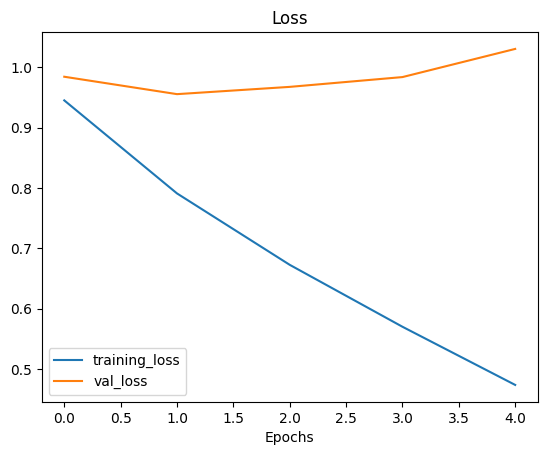

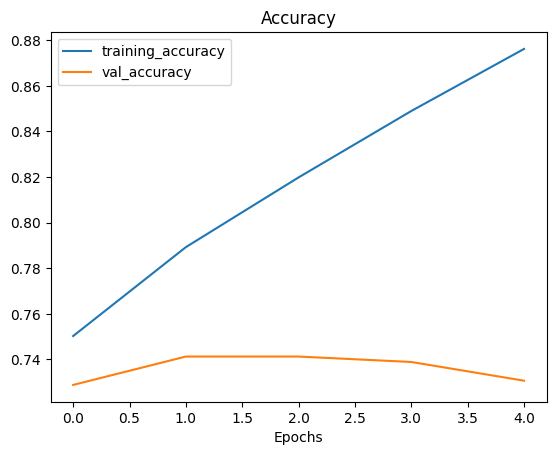

In [42]:
plot_loss_curves(history_model_2)

## Visualizing predictions

In [43]:
pred_probs = downloaded_gs_model.predict(test_data, verbose=1)
print(pred_probs[:10], pred_probs.shape)

790/790 [==============================] - 13s 14ms/step
[[1.6667657e-07 9.9318100e-09 1.6991324e-09 ... 4.4966411e-02
  9.4769996e-09 1.5904389e-07]
 [2.2150372e-05 2.8794092e-01 1.1419211e-08 ... 1.5763737e-07
  2.6815016e-07 1.3970067e-05]
 [1.5605043e-08 1.3011117e-09 9.8775488e-11 ... 3.2543126e-04
  2.2609932e-10 2.8702067e-08]
 ...
 [1.5452535e-08 4.1502590e-10 2.2341946e-11 ... 6.3321691e-06
  1.2268142e-10 1.5695878e-08]
 [7.2409434e-04 6.1195237e-06 1.5241797e-02 ... 4.2324942e-03
  9.5380731e-03 4.6026232e-04]
 [1.9417555e-05 3.4130210e-08 8.8527024e-08 ... 3.3219519e-06
  9.8759031e-08 1.9723337e-05]] (25250, 101)


In [44]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([83,  1, 45, 34, 23, 30, 72, 45,  8,  9])

In [51]:
true_classes = [ test_labels.numpy() for _, test_labels in test_data.unbatch() ]
true_classes[:10]

[83, 80, 45, 28, 23, 30, 72, 45, 94, 92]

In [52]:
## Accuracy score
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=true_classes, y_pred=pred_classes)
print(f"accuracy = {sklearn_accuracy}")

accuracy = 0.7335841584158416


## Confusion matrix

In [53]:
from helper_functions import make_confusion_matrix

make_confusion_matrix(y_true=true_classes,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=true_classes, y_pred=pred_classes))

classification_report_dict = classification_report(y_true=true_classes,
                                                   y_pred=pred_classes,
                                                   output_dict=True)
print(classification_report_dict)

In [ ]:
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']

class_f1_scores

In [56]:
# Create dataframe of f1 scores
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-scores": list(class_f1_scores.values())}).sort_values("f1-scores", ascending=False)

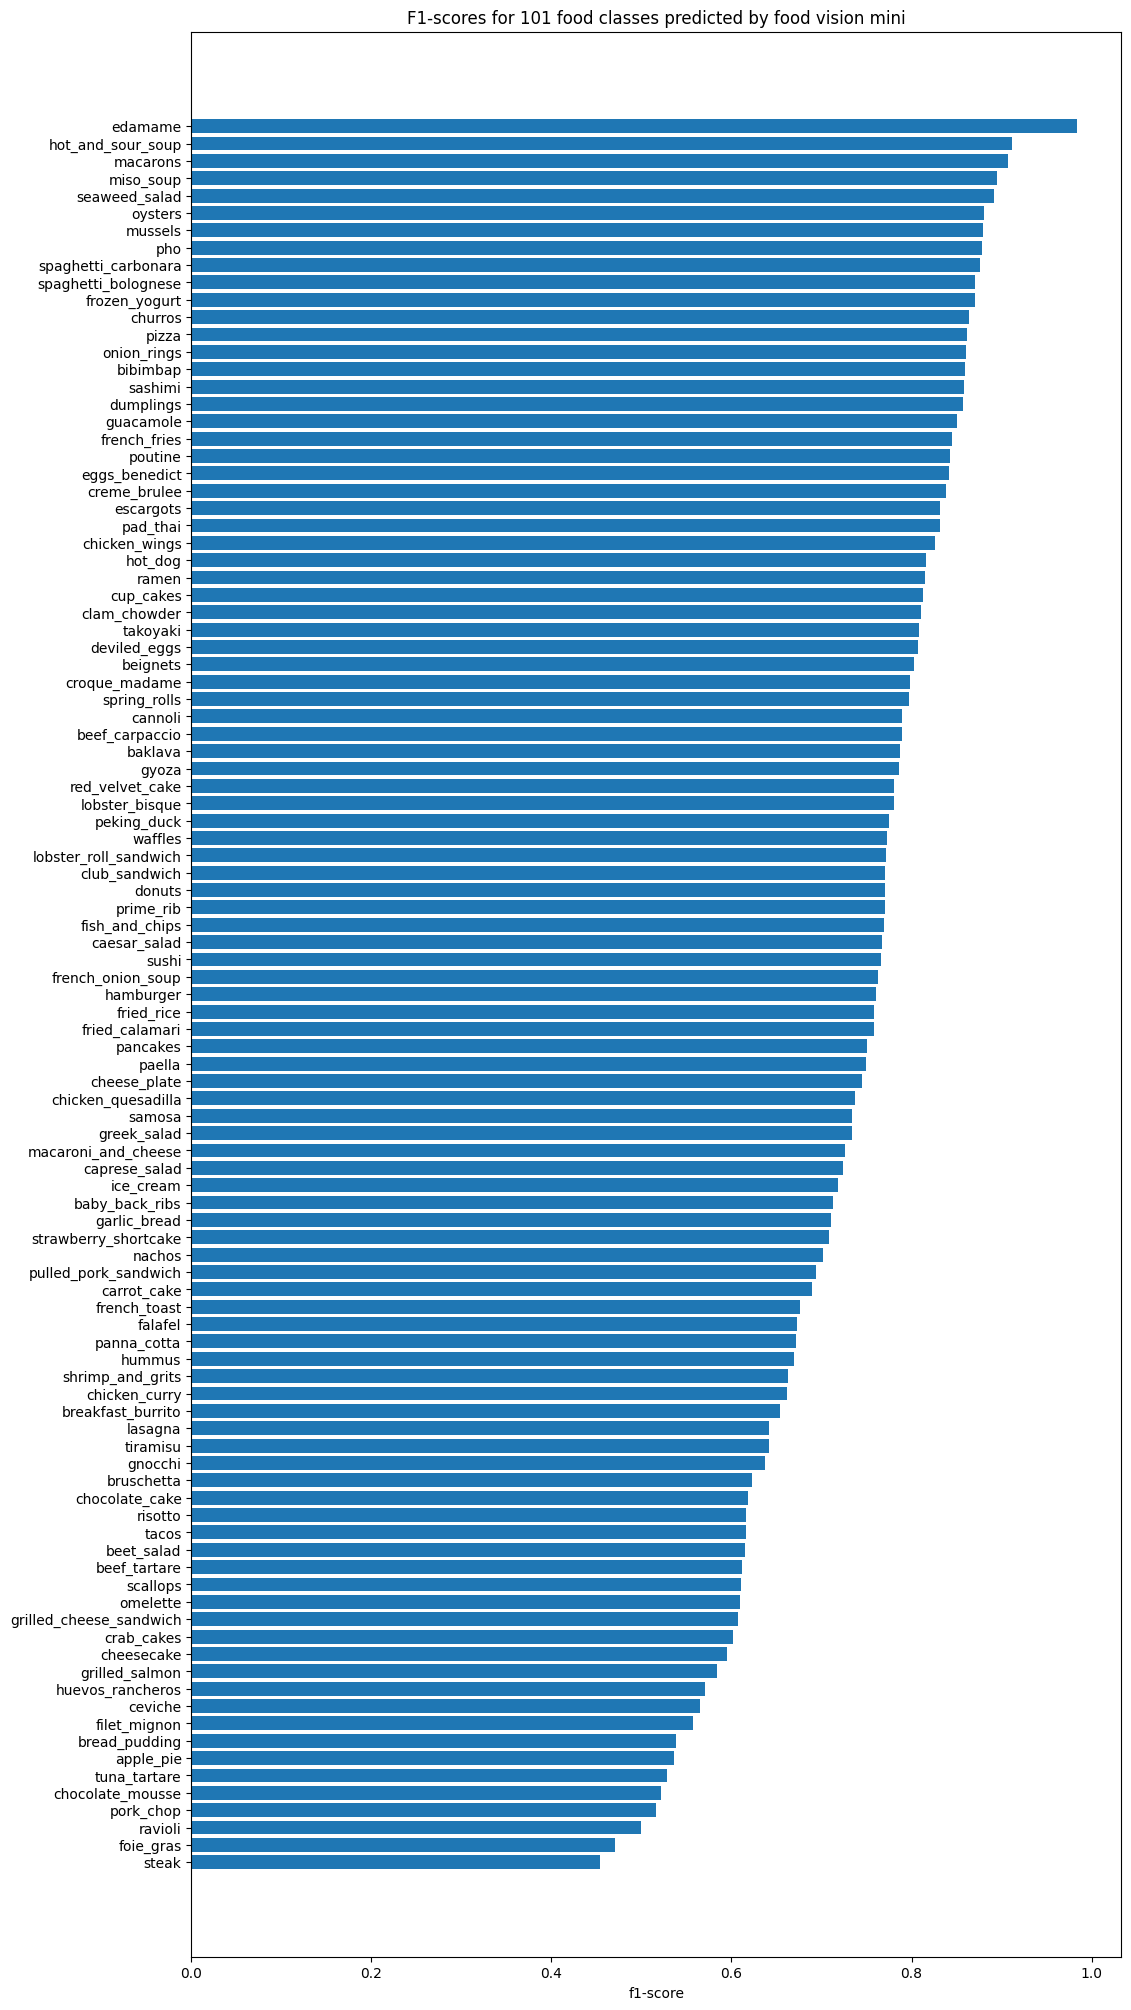

In [57]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-scores"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("f1-score")
ax.set_title("F1-scores for 101 food classes predicted by food vision mini")
ax.invert_yaxis()

In [66]:
data_unbatched =[(img, label) for img, label in test_data.unbatch()]

In [95]:
import os
import random

plt.figure(figsize=(17,10))
for i in range(9):
  img, class_name = random.choice(data_unbatched)
  class_name = class_names[class_name]
  processed_img, class_name = preprocess_img(img, class_name)
  pred_prob = downloaded_gs_model.predict(tf.expand_dims(processed_img,axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(3, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"

  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)

1/1 [==============================] - 0s 28ms/step


## Making predictions on custom images

In [96]:
def load_and_prep_image(file_name, img_shape=224, scale=True):

  img = tf.io.read_file(file_name)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.resize(img, size=[img_shape,img_shape])

  if scale:
    return img/255.
  else:
    return img


--2024-03-07 20:40:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.174.207, 108.177.125.207, 74.125.23.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.174.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  10.2MB/s    in 1.2s    

2024-03-07 20:40:06 (10.2 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]

1/1 [==============================] - 0s 29ms/step


prediction for pizza-dad.jpeg: pizza


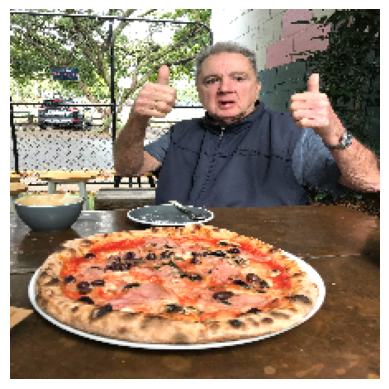

1/1 [==============================] - 0s 28ms/step


prediction for ramen.jpeg: chicken_curry


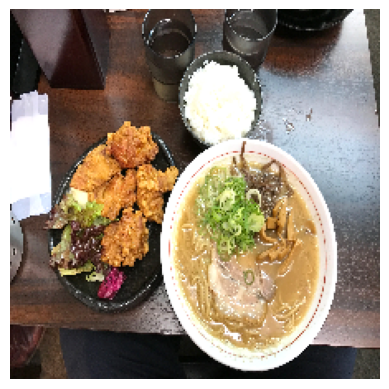

1/1 [==============================] - 0s 28ms/step


prediction for steak.jpeg: steak


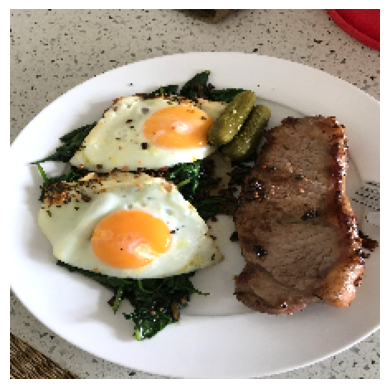

1/1 [==============================] - 0s 26ms/step


prediction for chicken_wings.jpeg: chicken_wings


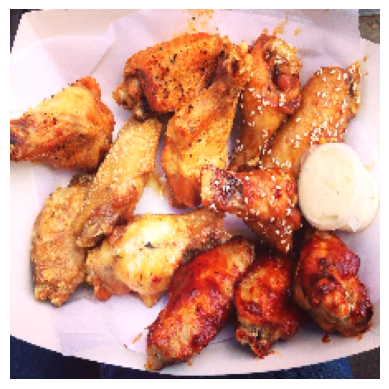

1/1 [==============================] - 0s 27ms/step


prediction for sushi.jpeg: sushi


1/1 [==============================] - 0s 27ms/step


prediction for hamburger.jpeg: hamburger


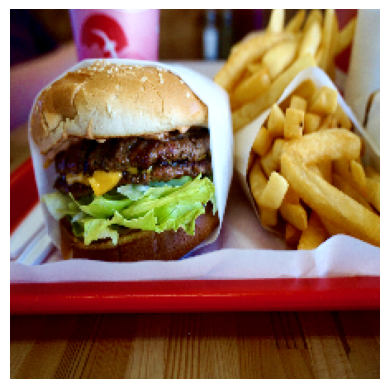

In [99]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

for file in os.listdir("custom_food_images"):
  img = load_and_prep_image("custom_food_images/" + file, scale=False)
  pred_prob = downloaded_gs_model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  print(f"prediction for {file}: {pred_class}")
  plt.figure()
  plt.imshow(img/225.)
  plt.axis(False)
  plt.show()